In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import tensorflow as tf

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model

In [4]:
# Unfortunately this URL doesn't work directly with pd.read_csv
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

File 'spam.csv' already there; not retrieving.



In [5]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [6]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [8]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
# rename columns to something better
df.columns = ['labels', 'data']

In [10]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

In [12]:
# split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [22]:
df_train

4620                   Received, understood n acted upon!
2102                             Audrie lousy autocorrect
3302           It'll be tough, but I'll do what I have to
3799    We tried to contact you re your reply to our o...
2857    In life when you face choices Just toss a coin...
                              ...                        
2659                                                Ok...
1629    Sounds like you have many talents! would you l...
3287    Someone U know has asked our dating service 2 ...
2383                               Your pussy is perfect!
108     I know! Grumpy old people. My mom was like you...
Name: data, Length: 3733, dtype: object

In [13]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [14]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 7185 unique tokens.


In [15]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (3733, 189)


In [16]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1839, 189)


In [17]:
# Create the model

# We get to choose embedding dimensionality
D = 20

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,)) # N * T
x = Embedding(V + 1, D)(i) # N * T * D
x = Conv1D(32, 3, activation='relu')(x)  #  N * T/3 * 32
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)  #  N * T/3/3 * 64
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)   #  N * T/3/3/3 * 128
x = GlobalMaxPooling1D()(x)    #  N * 128
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)


In [18]:
# Compile and fit
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data_train,
  Ytrain,
  epochs=5,
  validation_data=(data_test, Ytest)
)

Training model...
Train on 3733 samples, validate on 1839 samples
Epoch 1/5
3733/3733 [==============================] - 5s 1ms/sample - loss: 0.4055 - accuracy: 0.8586 - val_loss: 0.2830 - val_accuracy: 0.8679
Epoch 2/5
3733/3733 [==============================] - 3s 721us/sample - loss: 0.1609 - accuracy: 0.9255 - val_loss: 0.0882 - val_accuracy: 0.9712
Epoch 3/5
3733/3733 [==============================] - 3s 715us/sample - loss: 0.0256 - accuracy: 0.9914 - val_loss: 0.0688 - val_accuracy: 0.9826
Epoch 4/5
3733/3733 [==============================] - 3s 724us/sample - loss: 0.0063 - accuracy: 0.9976 - val_loss: 0.0727 - val_accuracy: 0.9810
Epoch 5/5
3733/3733 [==============================] - 3s 716us/sample - loss: 0.0036 - accuracy: 0.9992 - val_loss: 0.0751 - val_accuracy: 0.9831


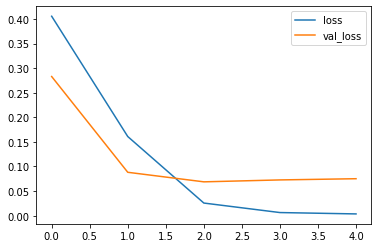

In [19]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

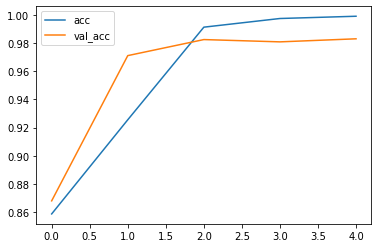

In [20]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()